In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
!kaggle datasets download -d shehzadhanif/eyes-open-closed-dataset

 98% 194M/197M [00:02<00:00, 89.8MB/s]
100% 197M/197M [00:02<00:00, 79.9MB/s]


# Downloading and preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/kaggle/eyeDataset/eyes-open-closed-dataset.zip'

!cp '{zip_path}' .

!unzip -q eyes-open-closed-dataset.zip

!rm eyes-open-closed-dataset.zip

In [ ]:
import skimage.io as imageio
import random

PATH = './Eye Dataset/Train_Data/open';
files = os.listdir(PATH)

for i in range(10):
  temp = random.choice(files);
  mar=cv2.imread(PATH + '/'+temp);
  print(mar.shape)

(126, 126, 3)
(90, 90, 3)
(88, 88, 3)
(131, 131, 3)
(85, 85, 3)
(117, 117, 3)
(119, 119, 3)
(94, 94, 3)
(91, 91, 3)
(132, 132, 3)


In [ ]:
import os
import shutil

In [ ]:
def moveImagesToClassFolders(dir):

  if(dir[-1] != '/'):
    print('Not a directory. Add / at end');
    return;



  #read all files
  #if file is opened
  #send to opened
  #if file is closed
  #send to closed


  files = os.listdir(dir)

  if 'open' not in files:
    os.mkdir(dir+'open/')

  if 'close' not in files:
    os.mkdir(dir+'close/')

  for file in files:
      if(file != 'open' and file != 'close'):
        word_label = file.split('_')[4]
        if word_label[0] == '1':#open 
            shutil.move(dir+file,dir+'open/')
            #print(file + ' -- open')  
        elif word_label[0] == '0':#close
            shutil.move(dir+file,dir+'close/')
            #print(file + ' -- close')

In [ ]:
moveImagesToClassFolders('./Eye Dataset/Test_Data/');

In [ ]:
moveImagesToClassFolders('./Eye Dataset/Train_Data/');

# CNN Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import albumentations as A
from torch.utils.data import DataLoader,Dataset
from skimage import io
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
class CNN(nn.Module):

  def __init__(self,in_channels = 1,num_classes = 10):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size = (3,3), stride=(1,1), padding=(1,1)) # same convolution as output size will be same
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.fc1 = nn.Linear(4096,num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc1(x)

    return x

In [ ]:
!pip install -q efficientnet_pytorch

In [ ]:

# from efficientnet_pytorch import EfficientNet

# model = EfficientNet.from_pretrained('efficientnet-b0')


# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model._fc.in_features
# model._fc = nn.Linear(num_ftrs,2);


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
inputs = torch.rand(1, 3, 224, 224)
model = EfficientNet.from_pretrained('efficientnet-b0')
for param in model.parameters():
  param.requires_grad = False

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs,2);
model.eval()
outputs = model(inputs)
print(outputs)


loss_func = nn.CrossEntropyLoss()
optimiser = optim.Adam(params=model.parameters(),lr=learning_rate)

Loaded pretrained weights for efficientnet-b0
tensor([[-0.1964,  0.0413]], grad_fn=<AddmmBackward0>)


In [ ]:
print(len(outputs[0]))

1000


In [ ]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyperparameters
input_size = 64*64
num_classes = 2
learning_rate = 0.001
batch_size = 128
num_epochs = 100

In [ ]:
device

device(type='cuda')

In [ ]:
#mean = torch.tensor([0.05438065, 0.05291743, 0.07920227])
#std = torch.tensor([0.39414383, 0.33547948, 0.38544176])

mean = torch.tensor([0.5])
std = torch.tensor([0.5])

transform = transforms.Compose([
                                 transforms.Resize(64),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5],std=[0.5],inplace=True)
                                ]);

#Vtransform = transforms.Compose([t,transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])


train_dataset = ImageFolder("./Eye Dataset/Train_Data/",transform=transform)
test_dataset = ImageFolder("./Eye Dataset/Test_Data/",transform=transform)

#splitting data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
!ls "./Eye Dataset/Train_Data/open" | wc -l
!ls "./Eye Dataset/Train_Data/close" | wc -l

8504
24119


In [ ]:
len(train_dataset.samples)

32623

TypeError: ignored

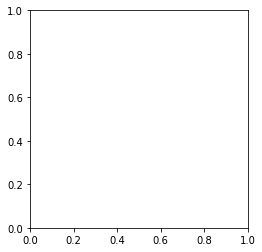

In [ ]:
import numpy as np

from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt
# arr = np.ndarray((1,80,80,1))#This is your tensor
# arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
# plt.imshow(arr_)
# plt.show()

for i in range(3,10):
  img = train_dataset[i][0]
  #im = transforms.ToPILImage()(img).convert("RGB")
  img = np.squeeze(img);
  #plt.imshow(im)
  plt.imshow(img)
  plt.show()

In [ ]:
train_dataset.class_to_idx

{'close': 0, 'open': 1}

In [ ]:
model = CNN(input_size,num_classes).to(device)

nSamples = [24119,8504]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).to(device)
loss_func = nn.CrossEntropyLoss(weight=normedWeights)
# loss_func = nn.CrossEntropyLoss()

optimiser = optim.Adam(params=model.parameters(),lr=learning_rate)

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
import torchvision

model = torchvision.models.mobilenet_v3_large()


for param in model.parameters():
  param.requires_grad = False

classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=2, bias=True)
)

model.classifier = classifier
loss_func = nn.CrossEntropyLoss()
optimiser = optim.Adam(params=model.parameters(),lr=learning_rate)
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
import torch
import sklearn
from sklearn.metrics import accuracy_score, f1_score

In [ ]:

train_f1 = [];
train_acc = [];
test_f1 = [];
test_acc = [];


model.train()

for epoch in range(num_epochs):


  train_targets = torch.tensor([]).to(device);
  train_predictions = torch.tensor([]).to(device);

  test_targets = torch.tensor([]).to(device);
  test_predictions = torch.tensor([]).to(device);


  #finding val accuracy
  model.train();

  #Training and also training accuracy

  for batch_idx, (data,targets) in enumerate(train_loader):
    
    data = data.to(device=device)
    targets = targets.to(device=device)

    #data = data.reshape(data.shape[0],-1) # means 1st dimension kept but others are flattened

    
    scores = model(data)

    _,predictions = torch.max(scores,1) # 1 is dimension i.e take max of matric in column
    
    train_targets = torch.cat((train_targets,targets));
    train_predictions = torch.cat((train_predictions,predictions));
    
    loss = loss_func(scores,targets)

    #remove gradient calculations from previous batch so it does not effect optimiser
    optimiser.zero_grad()

    #back propogate
    loss.backward()

    #take a single step to adjust weights
    optimiser.step()

  model.eval()
  for (data,targets) in test_loader:

    
    data = data.to(device=device)
    targets = targets.to(device=device)
    #data = data.reshape(data.shape[0],-1) # means 1st dimension kept but others are flattened
    scores = model(data)

    _,predictions =  torch.max(scores,1) # 1 is dimension i.e take max of matric in column
    test_targets = torch.cat((test_targets,targets));
    test_predictions = torch.cat((test_predictions,predictions));

  #------------------------------------------

  y_true = train_targets.cpu();
  y_pred = train_predictions.cpu(); 

  f1_sc = f1_score(y_true,y_pred);
  acc_sc = accuracy_score(y_true,y_pred);

  train_f1.append(f1_sc);
  train_acc.append(acc_sc);
  print(f'Train. F1: {f1_sc} Acc: {acc_sc}' )

  #------------------------------------------

  y_true = test_targets.cpu();
  y_pred = test_predictions.cpu(); 

  f1_sc = f1_score(y_true,y_pred);
  acc_sc = accuracy_score(y_true,y_pred);

  test_f1.append(f1_sc);
  test_acc.append(acc_sc);
  print(f'Test. F1: {f1_sc} Acc: {acc_sc}' )


Train. F1: 0.8183608709924499 Acc: 0.8982313091990314
Test. F1: 0.8797943851324634 Acc: 0.8746391752577319
Train. F1: 0.9134488873634231 Acc: 0.9536216779572694
Test. F1: 0.909220501522711 Acc: 0.9037113402061856
Train. F1: 0.9332106080653512 Acc: 0.9644116114397817
Test. F1: 0.8499548266036556 Acc: 0.851615120274914
Train. F1: 0.9421086114163437 Acc: 0.9693161266591055
Test. F1: 0.913029337149548 Acc: 0.9081099656357389
Train. F1: 0.9509696092619393 Acc: 0.9740367225577047
Test. F1: 0.9125771855703607 Acc: 0.9075601374570447
Train. F1: 0.9507135840989195 Acc: 0.9738528032369801
Test. F1: 0.9077783558792923 Acc: 0.9025429553264604
Train. F1: 0.9546953653879535 Acc: 0.9759985286454342
Test. F1: 0.9193975825738477 Acc: 0.9142955326460481
Train. F1: 0.9568586629655332 Acc: 0.9771326977899029
Test. F1: 0.935855160828719 Acc: 0.9291408934707904
Train. F1: 0.9605697411846448 Acc: 0.9791251570977532
Test. F1: 0.9379535558780842 Acc: 0.9294845360824743
Train. F1: 0.9612582398519718 Acc: 0.9794

TypeError: ignored

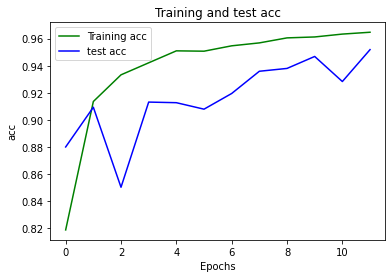

In [ ]:
acc_train =  train_f1;
acc_test = test_f1;
epochs = range(0,len(acc_test));
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_test, 'b', label='test acc')
plt.title('Training and test acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
torch.save(model.state_dict(),'./model_95.pt')

In [ ]:
torch.save(model,'./cnn_model_95');

In [ ]:
model = CNN()
model.load_state_dict(torch.load("./model_93.pt"))
model.eval()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

ytrue = []
ypred = []


model.eval()

with torch.no_grad():

  for x,y in test_loader:
    

    x = x.to(device=device)
    #x = x.reshape(x.shape[0],-1)

    scores = model(x)
    _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column


    ypred = ypred + predictions.tolist()
    ytrue = ytrue + y.tolist()
    
model.train()

print(confusion_matrix(ytrue, ypred))
print(accuracy_score(ytrue, ypred))
print(classification_report(ytrue, ypred))

## Old Way

In [ ]:
!unzip drive/MyDrive/eye_detection/eye_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: eye_dataset/close/s0019_01460_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0018_00966_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0014_01016_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0013_00701_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0013_01654_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0019_01859_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0014_03117_0_1_0_1_0_01.png  
  inflating: eye_dataset/close/s0013_01240_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0007_00130_0_0_0_0_1_01.png  
  inflating: eye_dataset/close/s0014_01685_0_0_0_0_0_01.png  
  inflating: eye_dataset/close/s0019_02713_0_0_0_0_1_01.png  
  inflating: eye_dataset/close/s0007_00546_0_0_0_0_1_01.png  
  inflating: eye_dataset/close/s0018_00172_0_0_0_0_1_01.png  
  inflating: eye_dataset/close/s0018_02805_0_1_0_0_0_01.png  
  inflating: eye_dataset/close/s0009_00260_0_0_0_0_0_01.png  
  inflating: eye_da

In [ ]:
import os


def getLastImgNumber(img_dir):
    files = os.listdir(img_dir)
    #files = [file if file[0] != 's' for file in files]

    for i in files:
        if (i.startswith("s") == False):
          print(i)
    #print(files)
    return len(files)


getLastImgNumber('./eye_dataset/close')

24119

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import albumentations as A
from torch.utils.data import DataLoader,Dataset
from skimage import io
import pandas as pd
import cv2
import matplotlib.pyplot as plt


In [ ]:
def get_train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train = Subset(dataset, train_idx)
    test = Subset(dataset, val_idx)
    return [train,test]

In [ ]:
class CNN(nn.Module):

  def __init__(self,in_channels = 1,num_classes = 10):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size = (3,3), stride=(1,1), padding=(1,1)) # same convolution as output size will be same
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.fc1 = nn.Linear(4096,num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc1(x)

    return x




In [ ]:
#ignore
model = CNN(num_classes=2)#open and closed
x= torch.randn(64,1,28)
print(x.shape)



torch.Size([64, 1, 28])


In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
model = efficientnet

In [ ]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyperparameters
input_size = 64*64
num_classes = 2
learning_rate = 0.001
batch_size = 128
num_epochs = 100

In [ ]:
class EyeDataset(Dataset):
    def __init__(self, csv_file, root_dir, Atransform=None,Vtransform=None):
        self.annotations = pd.read_csv(csv_file,index_col=0)
        self.root_dir = root_dir
        self.Atransform = Atransform
        self.Vtransform = Vtransform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        
        y_label = int(self.annotations.iloc[index, 1])
        img_folder = "open" if y_label == 0 else "close"

        img_path = os.path.join(self.root_dir,img_folder, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        #image = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
        y_label = torch.tensor(int(y_label))


        if self.Atransform:
            augmented = self.Atransform(image=image)
            image = augmented['image']

        if self.Vtransform:
            image = self.Vtransform(image)


        return image, y_label

In [ ]:
# transform = transforms.Compose([
#                                 transforms.ToPILImage(),
#                                 transforms.Resize((64,64)),
#                                 transforms.Grayscale(num_output_channels=1),
#                                 A.VerticalFlip(p=0.1),
#                                 A.HorizontalFlip(p=0.5),
#                                 A.Rotate(p=0.3),
#                                 A.OneOf([
#                                          A.GridDistortion(p=0.5),
#                                          A.IAAAdditiveGaussianNoise(p=0.3)
#                                 ]),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.5], std=[0.5]),
#                                 ]);

Atransform = A.Compose([
                       A.Resize(64,64),
                       #A.VerticalFlip(p=0.2),
                       A.HorizontalFlip(p=0.2),
                       #A.GridDistortion(p=1,num_steps=1,border_mode=cv2.BORDER_TRANSPARENT)
                       A.Rotate(p=0.3),
                       #A.OneOf([
                       #          A.GridDistortion(p=1,num_steps=2),
                       #          A.IAAAdditiveGaussianNoise(p=1,scale=(0.01 * 255, 0.02 * 255))
                       #]),
                       #A.IAAPiecewiseAffine(p=0)
                       
],p=1.0);

Vtransform = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])


dataset = EyeDataset(
    csv_file="drive/MyDrive/eye_detection/record.csv",
    root_dir="./eye_dataset",
    Atransform=Atransform,
    Vtransform=Vtransform
)

#print(len(dataset))
#print(dataset[0])

datasets = get_train_val_dataset(dataset)

train_dataset = datasets[0]
val_dataset = datasets[1]


#splitting data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=True)



32623


AttributeError: ignored

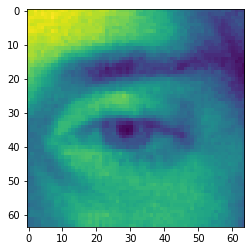

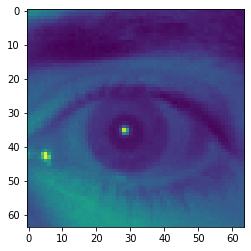

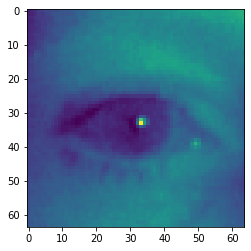

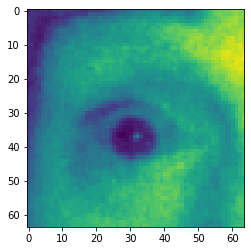

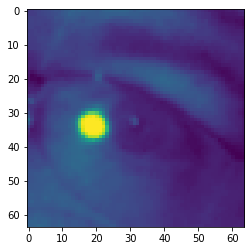

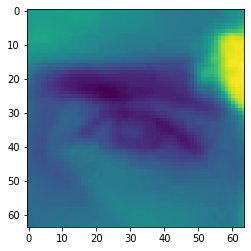

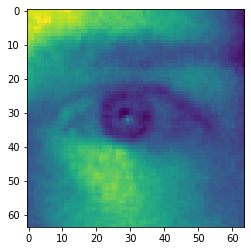

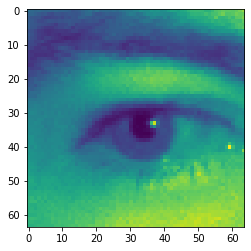

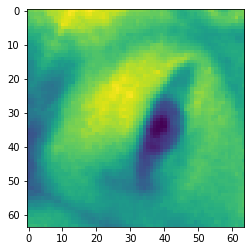

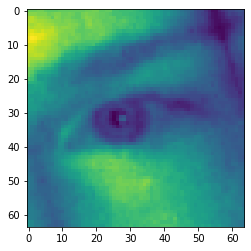

In [ ]:
# import matplotlib.pyplot as plt
# arr = np.ndarray((1,80,80,1))#This is your tensor
# arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
# plt.imshow(arr_)
# plt.show()

for i in range(10):
  img = dataset[i][0][0]
  plt.imshow(img)
  plt.show()

In [ ]:
# # # load data
# # train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform.ToTensor(), download=True)
# # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)

# # test_dataset = datasets.MNIST(root='dataset/',train=False, transform=transform.ToTensor(),download=True)
# # test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)


# #loading data
# transform = transforms.Compose([transforms.Resize((64,64)),
#                                 transforms.Grayscale(num_output_channels=1),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.5], std=[0.5]),
#                                 A.VerticalFlip(p=0.1),
#                                 A.HorizontalFlip(p=0.5),
#                                 A.Rotate(p=0.3),
#                                 A.OneOf([
#                                          A.GridDistortion(p=0.5),
#                                          A.IAAAdditiveGaussianNoise(p=0.3)
#                                 ]),
#                                 ]);

# dataset = ImageFolder(root='eye_dataset',transform=transform)


# print(dataset[0])

# datasets = get_train_val_dataset(dataset)

# train_dataset = datasets[0]
# val_dataset = datasets[1]


# #splitting data
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=True)

TypeError: ignored

In [ ]:
model = CNN(input_size,num_classes).to(device)

loss_func = nn.CrossEntropyLoss()
optimiser = optim.Adam(params=model.parameters(),lr=learning_rate)

In [ ]:
a = zip([(1,2),(1,2),(1,2)],[(3,4),(3,4),(3,4)])

for a,((b,c),(d,e)) in enumerate(a):
  print(e)

4
4
4


In [ ]:


model.train()


for epoch in range(num_epochs):


  #finding val accuracy

  num_correct_val = 0
  num_samples_val = 0


  for (data,targets) in val_loader:

    
    data = data.to(device=device)
    targets = targets.to(device=device)
    #data = data.reshape(data.shape[0],-1) # means 1st dimension kept but others are flattened
    scores = model(data)

    _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column
    num_correct_val += (predictions == targets).sum()
    num_samples_val += predictions.size(0)


  #Training and also training accuracy

  num_correct_train = 0
  num_samples_train = 0

  for batch_idx, (data,targets) in enumerate(train_loader):
    
    data = data.to(device=device)
    targets = targets.to(device=device)

    #data = data.reshape(data.shape[0],-1) # means 1st dimension kept but others are flattened

    
    scores = model(data)

    _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column
    num_correct_train += (predictions == targets).sum()
    num_samples_train += predictions.size(0)


    loss = loss_func(scores,targets)

    #remove gradient calculations from previous batch so it does not effect optimiser
    optimiser.zero_grad()

    #back propogate
    loss.backward()

    #take a single step to adjust weights
    optimiser.step()

  print(f'Train: Got {num_correct_train} / {num_samples_train} with accuracy {float(num_correct_train)/float(num_samples_train)*100:.2f}' )
  print(f'Val: Got {num_correct_val} / {num_samples_val} with accuracy {float(num_correct_val)/float(num_samples_val)*100:.2f}' )
  

Train: Got 22246 / 24467 with accuracy 90.92
Val: Got 5748 / 8156 with accuracy 70.48
Train: Got 23130 / 24467 with accuracy 94.54
Val: Got 7664 / 8156 with accuracy 93.97
Train: Got 23214 / 24467 with accuracy 94.88
Val: Got 7719 / 8156 with accuracy 94.64
Train: Got 23465 / 24467 with accuracy 95.90
Val: Got 7746 / 8156 with accuracy 94.97
Train: Got 23471 / 24467 with accuracy 95.93
Val: Got 7758 / 8156 with accuracy 95.12
Train: Got 23502 / 24467 with accuracy 96.06
Val: Got 7867 / 8156 with accuracy 96.46
Train: Got 23531 / 24467 with accuracy 96.17
Val: Got 7865 / 8156 with accuracy 96.43
Train: Got 23584 / 24467 with accuracy 96.39
Val: Got 7861 / 8156 with accuracy 96.38
Train: Got 23662 / 24467 with accuracy 96.71
Val: Got 7879 / 8156 with accuracy 96.60
Train: Got 23711 / 24467 with accuracy 96.91
Val: Got 7873 / 8156 with accuracy 96.53
Train: Got 23721 / 24467 with accuracy 96.95
Val: Got 7878 / 8156 with accuracy 96.59
Train: Got 23717 / 24467 with accuracy 96.93
Val: Got 

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [ ]:
def check_accuracy(model,data):
  
  num_correct = 0
  num_samples = 0

  model.eval()

  with torch.no_grad():

    for x,y in data:

      x = x.to(device=device)
      y = y.to(device=device)

      #x = x.reshape(x.shape[0],-1)

      scores = model(x)

      _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}' )


  model.train()


In [ ]:
check_accuracy(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Got 7910 / 8156 with accuracy 96.98


In [ ]:
from sklearn.metrics import confusion_matrix

ytrue = []
ypred = []


model.eval()

with torch.no_grad():

  for x,y in val_loader:

    x = x.to(device=device)
    #x = x.reshape(x.shape[0],-1)

    scores = model(x)
    _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column


    ypred = ypred + predictions.tolist()
    ytrue = ytrue + y.tolist()
    

print(confusion_matrix(ytrue, ypred))
print(accuracy_score(ytrue, ypred))
print(classification_report(ytrue, ypred))

KeyboardInterrupt: ignored

In [ ]:
#loading data
dataset = ImageFolder(root='./drive/MyDrive/dataset (copy)',transform=transforms.Compose([transforms.Resize((64,64)),transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])]))

mydata = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)


In [ ]:
from sklearn.metrics import confusion_matrix

ytrue = []
ypred = []


model.eval()

with torch.no_grad():

  for x,y in mydata:
    

    x = x.to(device=device)
    #x = x.reshape(x.shape[0],-1)

    scores = model(x)
    _,predictions = scores.max(1) # 1 is dimension i.e take max of matric in column


    ypred = ypred + predictions.tolist()
    ytrue = ytrue + y.tolist()
    

print(confusion_matrix(ytrue, ypred))
print(accuracy_score(ytrue, ypred))
print(classification_report(ytrue, ypred))

[[ 6144   261]
 [  324 17738]]
0.9760902440021253
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6405
           1       0.99      0.98      0.98     18062

    accuracy                           0.98     24467
   macro avg       0.97      0.97      0.97     24467
weighted avg       0.98      0.98      0.98     24467



The images below are from test data. However, they still show as close (0)

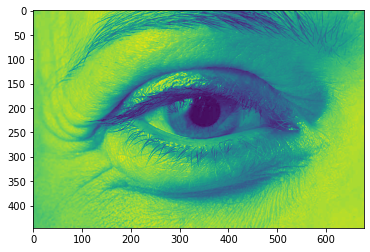

torch.Size([1, 1, 64, 64])
tensor([[-20.4107,  20.3134]], grad_fn=<AddmmBackward0>)
tensor([1])


In [ ]:
import numpy as np
import dlib
import time
import os
import re
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import cm

img = cv2.imread('eye2.jpg',0)
plt.imshow(img)
plt.show()

img = Image.fromarray(np.uint8(cm.gist_earth(img)*255))

preprocess = transforms.Compose([transforms.Resize((64,64)),transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
x = preprocess(img)
x = x[None,:,:,:]
print(x.shape)

x = x.to(device)

scores = model(x)
_,predictions = scores.max(1)

print(scores)
print(predictions)

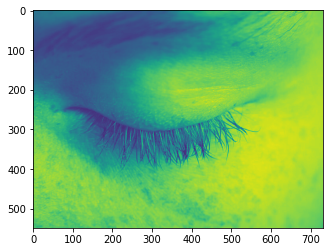

torch.Size([1, 1, 64, 64])
tensor([[-0.4278,  0.3991]], grad_fn=<AddmmBackward0>)
tensor([1])


In [ ]:
import numpy as np
import dlib
import time
import os
import re
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import cm

img = cv2.imread('eyee.jpg',0)
plt.imshow(img)
plt.show()

img = Image.fromarray(np.uint8(cm.gist_earth(img)*255))

preprocess = transforms.Compose([transforms.Resize((64,64)),transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
x = preprocess(img)
x = x[None,:,:,:]
print(x.shape)

x = x.to(device)

scores = model(x)
_,predictions = scores.max(1)

print(scores)
print(predictions)

In [ ]:
torch.save(model,"./checkpoint.pt")